В корне с файлом создаем папку "dataset". После скачивания [Simpsons Dataset](https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset?resource=download) кладем все в эту папку. Из основного после выполненных действий:
1. нам понадобятся данные для обучения, которые представлены в папке "simpsons_dataset" и имеют следующую структуру:
    - classname_1:
        - pic_{pic_number}.jpg
        - pic_{pic_number+1}.jpg
        - pic_n.jpg
    - classname_2:
        - pic_{pic_number}.jpg
        - pic_{pic_number+1}.jpg
        - pic_n.jpg
    - ...
    - classname_n:
        - pic_{pic_number}.jpg
        - pic_{pic_number+1}.jpg
        - pic_n.jpg
2. затем понадобятся данные для теста обучения, которые находятся в папке "kaggle_simpson_testset", которые имеют следующую структуру:
    - classname{name1}-label_{instance_1}.jpg
    - classname{name1}-label_{instance_2}.jpg
    - classname{name2}-label_{instance_1}.jpg
    - classname{name2}-label_{instance_2}.jpg
    - ...
    - classname{namen}-label_{instance_n}.jpg    
    
Так структура в пункте 2 не похожа на структуру из пункта 1, для единообразия нужно сделать ее похожей, для этого необходимо сначала запустить **testset_modify.py**

## Основной код обучения

In [2]:
import os
import time
import glob

from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.models import resnet18

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
sns.set_style(style='dark')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Устройство: {device}')
print(f'Версия pytorch: {torch.__version__}')

Устройство: cuda
Версия pytorch: 2.3.0.dev20240105+cu121


In [3]:
input_size: int = 224

train_data_dir: str = './dataset/simpsons_dataset/'
train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor()
])
train_dataset = torchvision.datasets.ImageFolder(
    train_data_dir,
    transform=train_transform
)

validate_data_dir: str = './dataset/kaggle_simpson_testset/'
validate_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor()
])
validate_dataset = torchvision.datasets.ImageFolder(
    validate_data_dir,
    transform=validate_transform
)

print(f'Классов в тренировочном датасете: {len(train_dataset.classes)}')
print(f'Классов в валидационном датасете: {len(validate_dataset.classes)}')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8,6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=600)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

Классов в тренировочном датасете: 42
Классов в валидационном датасете: 20


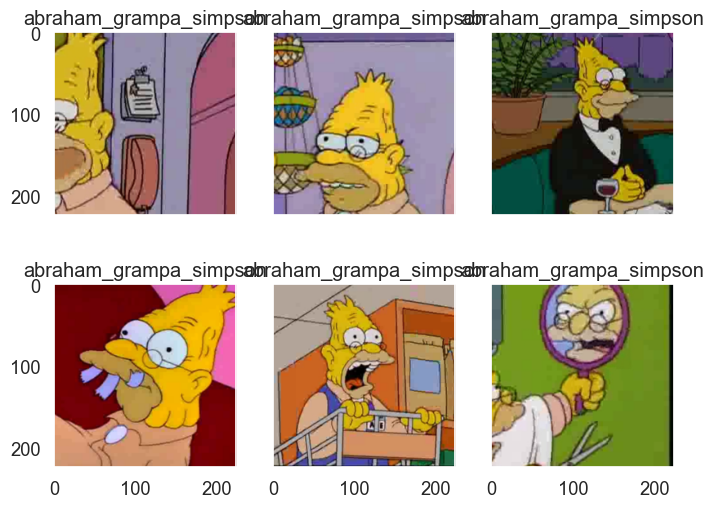

In [4]:
show_images(train_dataset)

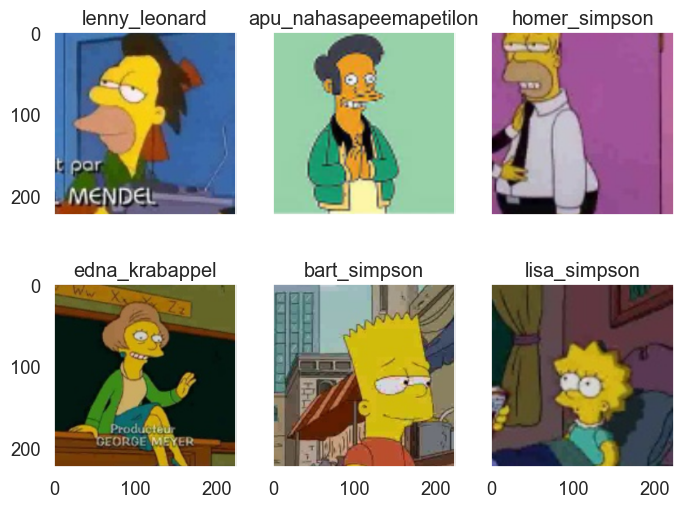

In [5]:
show_images(validate_dataset)

Epoch 20 of 20 took 428.105s
    training loss (in-iteration): 	0.007327
    validation loss (in-iteration): 	17.116836
    training accuracy: 			99.94%
    validation accuracy: 		4.30%


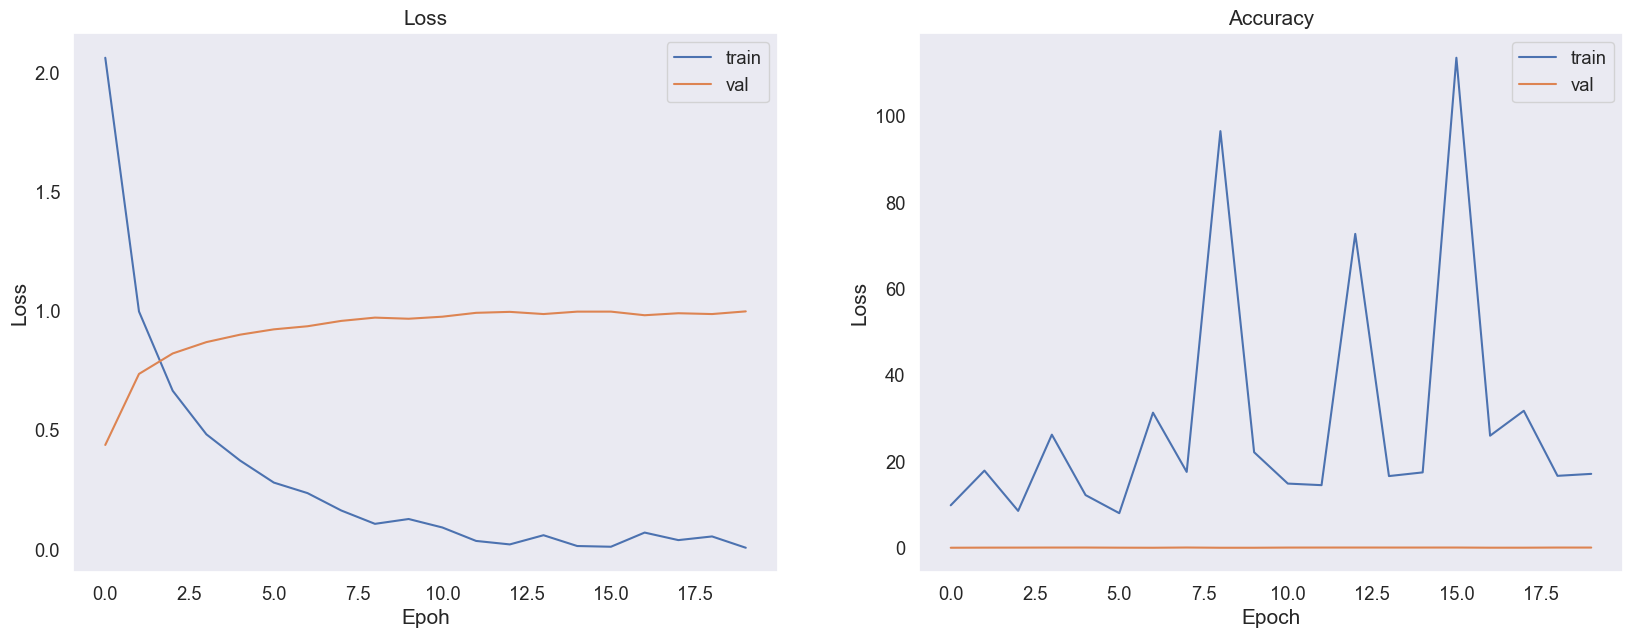

In [6]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1, 2, 1)
    plt.title('Loss', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['acc']['train'], label='val')
    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Epoh', fontsize=15)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Accuracy', fontsize=15)
    plt.plot(history['loss']['val'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.legend()

    plt.show()

def train(
    model: torchvision.models.ResNet,
    criterion,
    optimizer: torch.optim.SGD,
    train_batch_gen,
    validate_batch_gen,
    num_epochs=10
):
    '''
    Фцнкция обучения модели и вывода лосса и метрики во время обучения
    '''
    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        validate_loss = 0
        validate_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm в обучение
        model.train(True)

        for x_batch, y_batch in train_batch_gen:
            # обучаем на текущем батче
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(x_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраняем в историю
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for x_batch, y_batch in validate_batch_gen:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(x_batch)
            loss = criterion(logits, y_batch.long().to(device))
            validate_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            validate_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраняем историю
        validate_loss /= len(validate_batch_gen)
        validate_acc /= len(validate_batch_gen)
        history['loss']['val'].append(validate_loss)
        history['acc']['val'].append(validate_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print('Epoch {} of {} took {:.3f}s'.format(epoch + 1, num_epochs, time.time() - start_time))
        print('    training loss (in-iteration): \t{:.6f}'.format(train_loss))
        print('    validation loss (in-iteration): \t{:.6f}'.format(validate_loss))
        print('    training accuracy: \t\t\t{:.2f}%'.format(train_acc * 100))
        print('    validation accuracy: \t\t{:.2f}%'.format(validate_acc * 100))

        plot_learning_curves(history)

    return model, history

batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

validate_batch_gen = torch.utils.data.DataLoader(
    validate_dataset, batch_size=batch_size, shuffle=False
)

model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen, validate_batch_gen,
    num_epochs=20
)

